# Méthode globale

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
import math

In [80]:
class Linear_Regression_Global:

    def fit(self, X, y, method, learning_rate=0.01, iterations=500, batch_size=32):            # X peut être de la taille que l'on veut
        X = tf.concat([X, tf.ones_like(y, dtype=tf.float32)], axis=1)
        rows, cols = X.shape
        if method == 'direct':
            if rows >= cols == tf.linalg.matrix_rank(X):
                self.weights = tf.linalg.matmul(tf.linalg.matmul(tf.linalg.inv(tf.linalg.matmul(X,X,transpose_a=True)),X,transpose_b=True),y)
            else:
                print('X has not full column rank. method=\'direct\' cannot be used.')
        elif method == 'mco':
            self.weights = tf.Variable(tf.random.normal(stddev=1.0/cols, shape=(cols, 1)))
            for i in range(iterations):
                Xy = tf.concat([X, y], axis=1)
                Xy = tf.random.shuffle(Xy)
                X, y = tf.split(Xy, [Xy.shape[1]-1, 1], axis=1)
                for j in range(int(math.ceil(rows/batch_size))):
                    begin, size = batch_size*j, batch_size if batch_size*(j+1) < rows else -1
                    Xb, yb = tf.slice(X, [begin, 0], [size, -1]), tf.slice(y, [begin, 0], [size, -1])
                    
                    with tf.GradientTape() as tape:
                        diff = tf.math.subtract(tf.linalg.matmul(Xb, self.weights), yb)
                        loss_value = tf.linalg.matmul(diff, diff, transpose_a=True)
                    gradient = tape.gradient(loss_value, self.weights)
                    self.weights.assign_sub(tf.multiply(learning_rate, gradient))
        else:
            print(f'Unknown method: \'{method}\'. Use "direct" or "mco".')

        return self
    
    def predict(self, X):
        if not hasattr(self, 'weights'):
            print('Cannot predict. You should call the .fit() method first.')
            return
        
        X = tf.concat([X, tf.ones((X.shape[0], 1), dtype=tf.float32)], axis=1)
        
        if X.shape[1] != self.weights.shape[0]:
            print(f'Shapes do not match. {X.shape[1]} != {self.weights.shape[0]}')
            return
        
        return tf.linalg.matmul(X, self.weights)
    
    def rmse(self, X, y):
        y_hat = self.predict(X)
        
        if y_hat is None:
            return
        
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.pow(tf.math.subtract(y_hat, y), 2)))

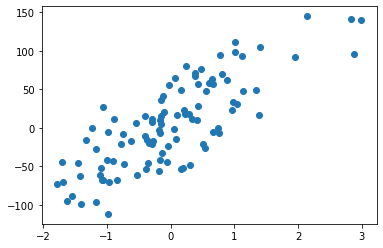

In [81]:
X, y = make_regression(n_features=1, n_informative=1, bias=1, noise=35)         # X ici vaut x car c'est de taille 1 (1 input)
plt.scatter(X, y)

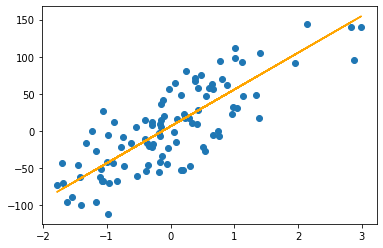

In [82]:
y = y.reshape((-1, 1))
lr_solve = Linear_Regression_Global().fit(X, y, method='mco')
plt.scatter(X, y)
plt.plot(X, lr_solve.predict(X), color='orange')

# Cas particulier des moindres carrés ordinaire avec une seule variable

In [67]:
class Linear_Regression_MCO :

    def fit(self, X, y, learning_rate, iterations):
        X = tf.concat([X, tf.ones_like(y, dtype=tf.float32)], axis=1)
        self.weights = tf.Variable(tf.random.normal(stddev=1/2, shape=(2, 1)))
        for i in range(iterations):
            with tf.GradientTape() as tape:
                diff = tf.math.subtract(tf.linalg.matmul(X, self.weights), y)
                loss_value = tf.linalg.matmul(diff, diff, transpose_a=True)           # Moindres carrés ordinaires
            gradient = tape.gradient(loss_value, self.weights)
            self.weights.assign_sub(tf.multiply(learning_rate, gradient))             # weights = weights - learning_rate * gradient
        return self    
    
    def predict(self, X):
        X = tf.concat([X, tf.ones_like(y, dtype=tf.float32)], axis=1)
        return tf.linalg.matmul(X, self.weights)

    def rmse(self, X, y):
        y_hat = self.predict(X)
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.pow(tf.math.subtract(y_hat, y), 2)))

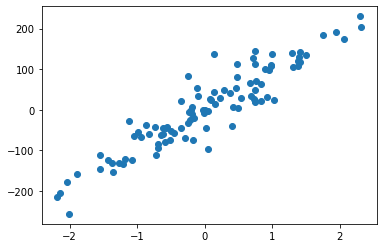

In [68]:
X, y = make_regression(n_features=1, n_informative=1, bias=1, noise=35)
plt.scatter(X, y)

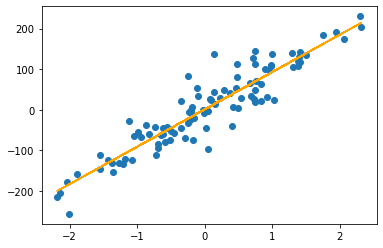

In [73]:
y = y.reshape((-1, 1))
lr_solve = Linear_Regression_MCO().fit(X, y, learning_rate = 0.0005, iterations = 500)
plt.scatter(X, y)
plt.plot(X, lr_solve.predict(X), color='orange')